### Failure Classification & Clustering Analysis

[DEBUG] 解析后数据量: 348340

[Logistic Regression]

              precision    recall  f1-score   support

           0       1.00      0.78      0.87      8878
           1       0.06      0.99      0.11       122

    accuracy                           0.78      9000
   macro avg       0.53      0.88      0.49      9000
weighted avg       0.99      0.78      0.86      9000

Confusion Matrix:
 [[6887 1991]
 [   1  121]]
ROC AUC: 0.9179810842052005

[Random Forest]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8878
           1       0.90      0.92      0.91       122

    accuracy                           1.00      9000
   macro avg       0.95      0.96      0.95      9000
weighted avg       1.00      1.00      1.00      9000

Confusion Matrix:
 [[8866   12]
 [  10  112]]
ROC AUC: 0.9872155890966433

[XGBoost Classifier]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8878
 

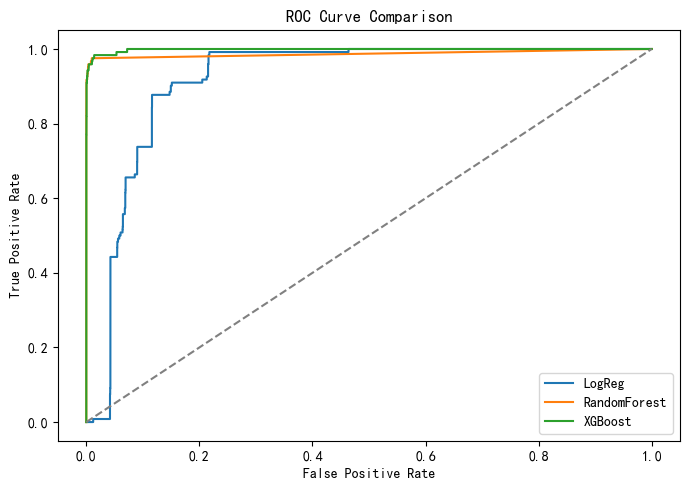

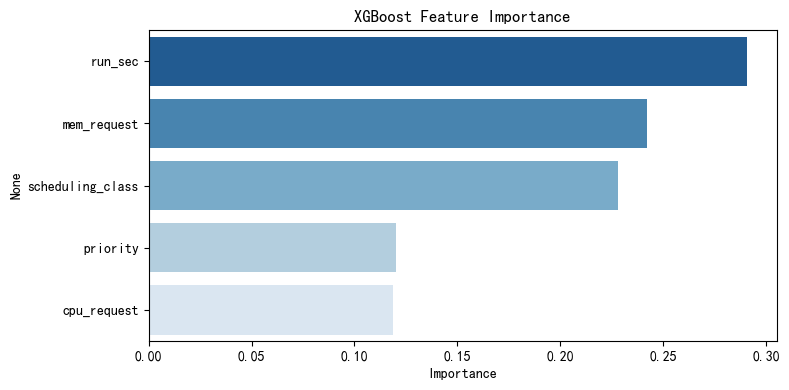

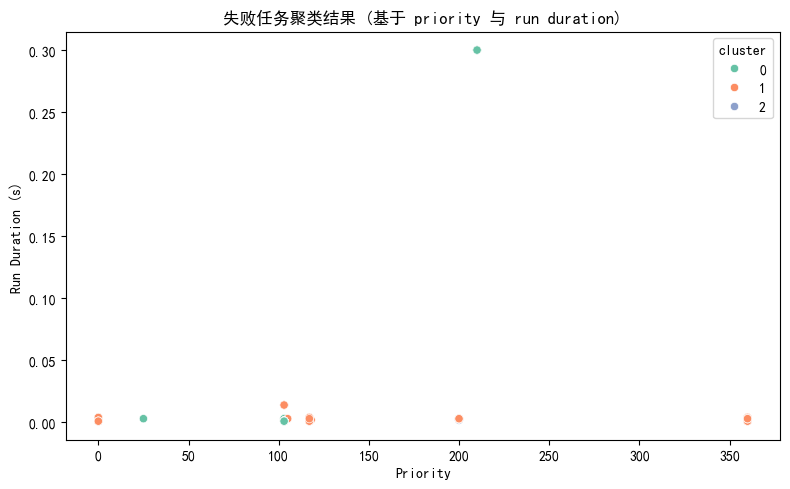

In [13]:
# Failure Classification & Clustering Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract

# 初始化 Spark
spark = SparkSession.builder \
    .appName("Failure Prediction and Clustering") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# 读取数据
sdf = spark.read.parquet("../data/cleaned_borg_data.parquet")

# 提取字段（修正正则表达式）
pattern_cpu = r"[\"']cpus[\"']\s*:\s*([\d.]+)"
pattern_mem = r"[\"']memory[\"']\s*:\s*([\d.]+)"
sdf_parsed = sdf.filter(
    col("failed").isNotNull() &
    col("priority").isNotNull() &
    col("scheduling_class").isNotNull() &
    col("resource_request").isNotNull() &
    col("run_duration").isNotNull()
).withColumn(
    "cpu_request", regexp_extract(col("resource_request"), pattern_cpu, 1).cast("double")
).withColumn(
    "mem_request", regexp_extract(col("resource_request"), pattern_mem, 1).cast("double")
).withColumn(
    "run_sec", (col("run_duration") / 1e9).cast("double")
).filter((col("cpu_request") > 0) & (col("mem_request") > 0))

# 检查数据量
print(f"[DEBUG] 解析后数据量: {sdf_parsed.count()}")

# 转换为 Pandas 前确保数据存在
features = ["priority", "scheduling_class", "cpu_request", "mem_request", "run_sec"]
if sdf_parsed.count() == 0:
    raise ValueError("无有效数据，请检查过滤条件或数据源。")

pdf = sdf_parsed.select(*features, "failed").limit(30000).toPandas()

# Logistic Regression（二分类）
features = ["priority", "scheduling_class", "cpu_request", "mem_request", "run_sec"]
X = pdf[features]
y = pdf["failed"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("\n[Logistic Regression]\n")
clf_lr = LogisticRegression(class_weight='balanced')
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_prob_lr = clf_lr.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_lr, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))

# Random Forest
print("\n[Random Forest]\n")
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

# XGBoost
print("\n[XGBoost Classifier]\n")
clf_xgb = XGBClassifier(eval_metric='logloss', random_state=42)
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)
y_prob_xgb = clf_xgb.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))

# 绘制 ROC 对比图
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_rf, tpr_rf, label="RandomForest")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(8, 4))
importance = pd.Series(clf_xgb.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(
    x=importance.values, 
    y=importance.index, 
    hue=importance.index,  # 添加 hue 参数
    palette="Blues_r", 
    legend=False  # 关闭图例
)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 聚类分析：仅对失败任务分析其模式
failed_df = pdf[pdf["failed"] == 1].copy()
X_failed = scaler.fit_transform(failed_df[features])

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_failed)
failed_df["cluster"] = kmeans.labels_

# 可视化聚类结果（以 priority 和 run_sec 为例）
plt.figure(figsize=(8, 5))
sns.scatterplot(data=failed_df, x="priority", y="run_sec", hue="cluster", palette="Set2")
plt.title("失败任务聚类结果 (基于 priority 与 run duration)")
plt.xlabel("Priority")
plt.ylabel("Run Duration (s)")
plt.tight_layout()
plt.show()

spark.stop()